# Kunjal Patel

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np



# Build an Autoencoder for a human face dataset

We will use a dataset containig images of people and train an autoencoder on it. 

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [2]:

path = 'lfw'

In [3]:
transform = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)

This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [4]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")


torch.Size([256, 256, 3])


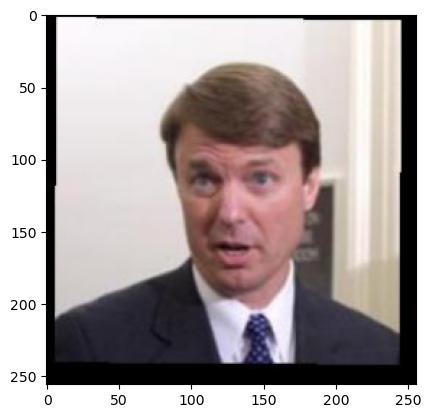

In [5]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

## Step 2
Each datapoint is an image. Get a sample of the data and print its dimensions and explain what each dimension means.

In [6]:
# Looping through the dataloader to obtain one batch
for data_sample, labels in dataloader:
    # Outputting the shape of the data sample
    print(f"Dimensions of the Data Sample: {data_sample.shape}")

    # Unpacking the dimensions for clarity
    size_of_batch, num_of_channels, img_height, img_width = data_sample.shape
    print(f"Size of Batch: {size_of_batch}")
    print(f"Channels Count: {num_of_channels}")
    print(f"Height of Image: {img_height}")
    print(f"Width of Image: {img_width}")
    
    # Exiting the loop after processing the first batch
    break


Dimensions of the Data Sample: torch.Size([32, 3, 256, 256])
Size of Batch: 32
Channels Count: 3
Height of Image: 256
Width of Image: 256


# Step 3

Create a new pytorch model calss for your autoencoder. You can use Conv2d, MaxPool2d, BatchNorm2d, ConvTranspose2d and Linear Layers as as well as activation functions. Optionally, you can use UpSample, AveragePool2d and Interpolate2d as well.

**Create seperate functions for the encoder and decoder.**

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()

        # Encoder layers
        self.encoder_conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1)
        self.encoder_bn1 = nn.BatchNorm2d(32)
        self.encoder_conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.encoder_bn2 = nn.BatchNorm2d(64)
        self.encoder_conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.encoder_bn3 = nn.BatchNorm2d(128)

        # Decoder layers
        self.decoder_conv1 = nn.ConvTranspose2d(128, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.decoder_bn1 = nn.BatchNorm2d(32)
        self.decoder_conv2 = nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.decoder_bn2 = nn.BatchNorm2d(3)

        # Additional decoder layers
        self.decoder_conv3 = nn.ConvTranspose2d(3, 3, kernel_size=3, stride=1, padding=1)

    def encoder(self, x):
        x = F.relu(self.encoder_bn1(self.encoder_conv1(x)))
        x = F.relu(self.encoder_bn2(self.encoder_conv2(x)))
        x = F.relu(self.encoder_bn3(self.encoder_conv3(x)))
        return x

    def decoder(self, x):
        # Adjust the ConvTranspose2d layer to compensate for the reduction in encoder
        x = F.relu(self.decoder_bn1(self.decoder_conv1(x)))
        x = F.relu(self.decoder_bn2(self.decoder_conv2(x)))
        x = torch.sigmoid(self.decoder_conv3(x))  # Removed unnecessary decoder_bn3
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)  # Upsample to match input size
        return x

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Create an instance of the AE model
autoencoder = AE()



## Step 4
Create an instance of the class, pass an image to the model, print the shape of the output of the **encoder** and the **decoder**. Check the dimensions and make sure your forward path is working properly.

In [8]:
# Get a sample from the dataloader
for x, y in dataloader:
    sample_image = x[0]  # Take the first image from the batch as a sample
    break

# Reshape the sample image to include a batch dimension
sample_image = sample_image.unsqueeze(0)

# Convert the sample image to MPSFloatType explicitly
sample_image = Variable(sample_image).to(dtype=torch.float32).to('mps')

# Ensure the autoencoder model is on the MPS device
autoencoder.to('mps')

# Pass the sample image through the autoencoder
encoded_output = autoencoder.encoder(sample_image)
decoded_output = autoencoder.decoder(encoded_output)

# Print the shapes of encoder and decoder outputs
print(f"Shape of Encoder Output: {encoded_output.shape}")
print(f"Shape of Decoder Output: {decoded_output.shape}")


Shape of Encoder Output: torch.Size([1, 128, 32, 32])
Shape of Decoder Output: torch.Size([1, 3, 256, 256])


##  Step 5
Print total number of parameters in the model, explain what loss function you should use, create an optimizer for training

In [9]:
total_params = sum(p.numel() for p in autoencoder.parameters())
print(f"Total Number of Parameters: {total_params}")

import torch.nn as nn
import torch.optim as optim

# Your Autoencoder class definition

autoencoder = AE()

# Print total number of parameters
total_params = sum(p.numel() for p in autoencoder.parameters())
print(f"Total Number of Parameters: {total_params}")

# Loss function
criterion = nn.MSELoss()

# Optimizer
learning_rate = 0.001  # Adjust as needed
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)


Total Number of Parameters: 131613
Total Number of Parameters: 131613


##  Step 6
Write a training loop and start trainng the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [10]:
num_epochs = 12  # You can adjust this value

for epoch in range(num_epochs):
    total_loss = 0.0

    # Training
    for batch in dataloader:
        inputs, _ = batch

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = autoencoder(inputs)
        print(f"Input Shape: {inputs.shape}, Output Shape: {outputs.shape}")

        loss = criterion(outputs, inputs)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Print average loss for the epoch
    average_loss = total_loss / len(dataloader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}')

# Training complete
print('Finished Training')


Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 

Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 

Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 

Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 

Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 

Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 

Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 

Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 

Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 

Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 

Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 

Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 

Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 

Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 

Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 

Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 

Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 

Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 

Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 

Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 

Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 

Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 

Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([21, 3, 256, 256]), Output Shape: torch.Size([21, 3, 256, 256])
Epoch [5/12], Loss: 0.0016
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input

Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 

Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 

Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 

Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 

Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 

Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 

Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 

Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 

Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 

Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 

Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 

Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 

Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 

Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 

Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 

Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 

Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 

Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 

Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 

Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 

Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 

Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 

Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 

Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 

Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 

Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 

Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 

Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 

Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 

Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 256, 256]), Output Shape: torch.Size([32, 3, 256, 256])
Input Shape: torch.Size([32, 3, 

##  Step 7

Take a random image from the dataset and plot it against the reconstructed (encoded + decoded) image.

Original Image:


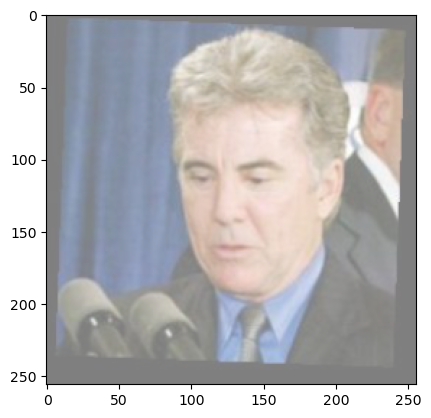

Reconstructed Image:


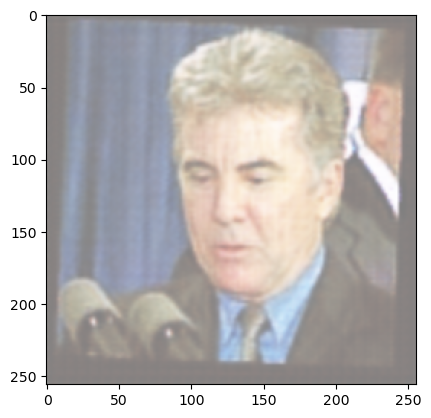

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision


# Function to display images
def imshow(img):
    img = img.detach()  # Detach the tensor from the computation graph
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get a random batch of images from the dataset
dataiter = iter(dataloader)
images, _ = next(dataiter)
random_image = images[0].unsqueeze(0)


# Pass the random image through the autoencoder
reconstructed_image = autoencoder(random_image)

# Display the original and reconstructed images
print("Original Image:")
imshow(torchvision.utils.make_grid(random_image))

print("Reconstructed Image:")
imshow(torchvision.utils.make_grid(reconstructed_image.detach()))


##  Step 8

In step 7, add a small normaly distrubuted noise to the latent (hidden) representation of the input image and then decode it again. How is adding noise affecting the decoded image ?

Original:


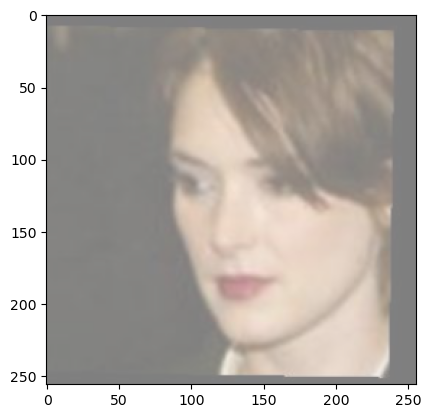

Reconstructed:


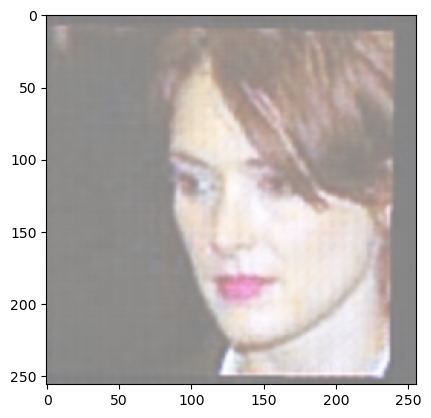

Perturbed Reconstructed Image:


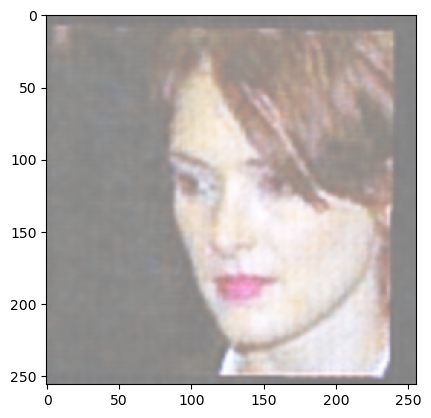

In [18]:

# Your existing code for the autoencoder class and dataset loading

# Load the dataset and create the dataloader
path = 'lfw'
transform = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])
dataloader = DataLoader(ImageFolder(path, transform), batch_size=32, shuffle=True)

# Function to add noise to the latent representation
def add_noise(latent_representation, noise_factor=0.2):
    noise = torch.randn_like(latent_representation) * noise_factor
    perturbed_latent = latent_representation + noise
    return perturbed_latent

# Get a random image from the dataset
dataiter = iter(dataloader)
images, _ = dataiter.__next__()
random_image = images[0].unsqueeze(0)

encoded_output = autoencoder.encoder(random_image)
decoded_output = autoencoder.decoder(encoded_output)

print("Original:")
imshow(torchvision.utils.make_grid(random_image))

print("Reconstructed:")
imshow(torchvision.utils.make_grid(decoded_output))

# Add noise to the latent representation and decode again
perturbed_latent = add_noise(encoded_output)
perturbed_decoded_output = autoencoder.decoder(perturbed_latent)

print("Perturbed Reconstructed Image:")
imshow(torchvision.utils.make_grid(perturbed_decoded_output))
